# Imports

In [1]:
import torch
import os
import numpy as np
import scipy.optimize as opt
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt


from models.trained_models.unet_wavelet import UNetWavelet

from utils.image_helpers import plot_image_grid, image_to_tensor, tensor_to_image
from fitting.FittingConfiguration import FittingConfiguration
from fitting.Fitter import fit_model
from simulation.SimulationPipeline import SimulationPipeline
from utils.fwhm_helpers import calculate_fwhm

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


# Create Image

In [2]:
def create_vertical_contrast(size):
    return np.concatenate((np.ones((size[0],size[1]//2)), np.zeros((size[0],size[1]//2))), axis=1)

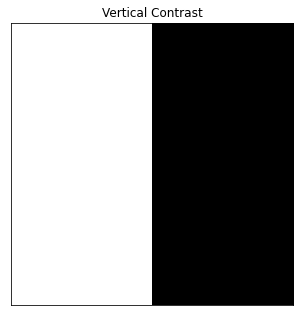

In [3]:
input_size = (100, 100)
original_image = create_vertical_contrast(input_size)
plot = plot_image_grid([original_image], ['Vertical Contrast'], ncols=1)

# Gibbs Simulation

In [4]:
cnr_range = [2, 4, 8, 16, 32, 64]
k_factors = list(np.arange(1,10)/10)
images_per_setting = 10

In [5]:
noisy_images = []
param_descriptions = []

cnrs, ks = np.meshgrid(cnr_range, k_factors)
cnrs = cnrs.flatten()
ks = ks.flatten()

for param_index, (cnr, k) in enumerate(zip(cnrs, ks)):
    print(f'Parameter Combination {param_index+1}/{len(cnrs.flatten())}', end='\r')
    pipeline = SimulationPipeline(k_factor=k, snr=cnr/2, pf_factor=1.0)
    for index in range(images_per_setting):
        noisy_image = pipeline.simulate(original_image)
        noisy_images.append(noisy_image)
        param_descriptions.append((cnr, k))

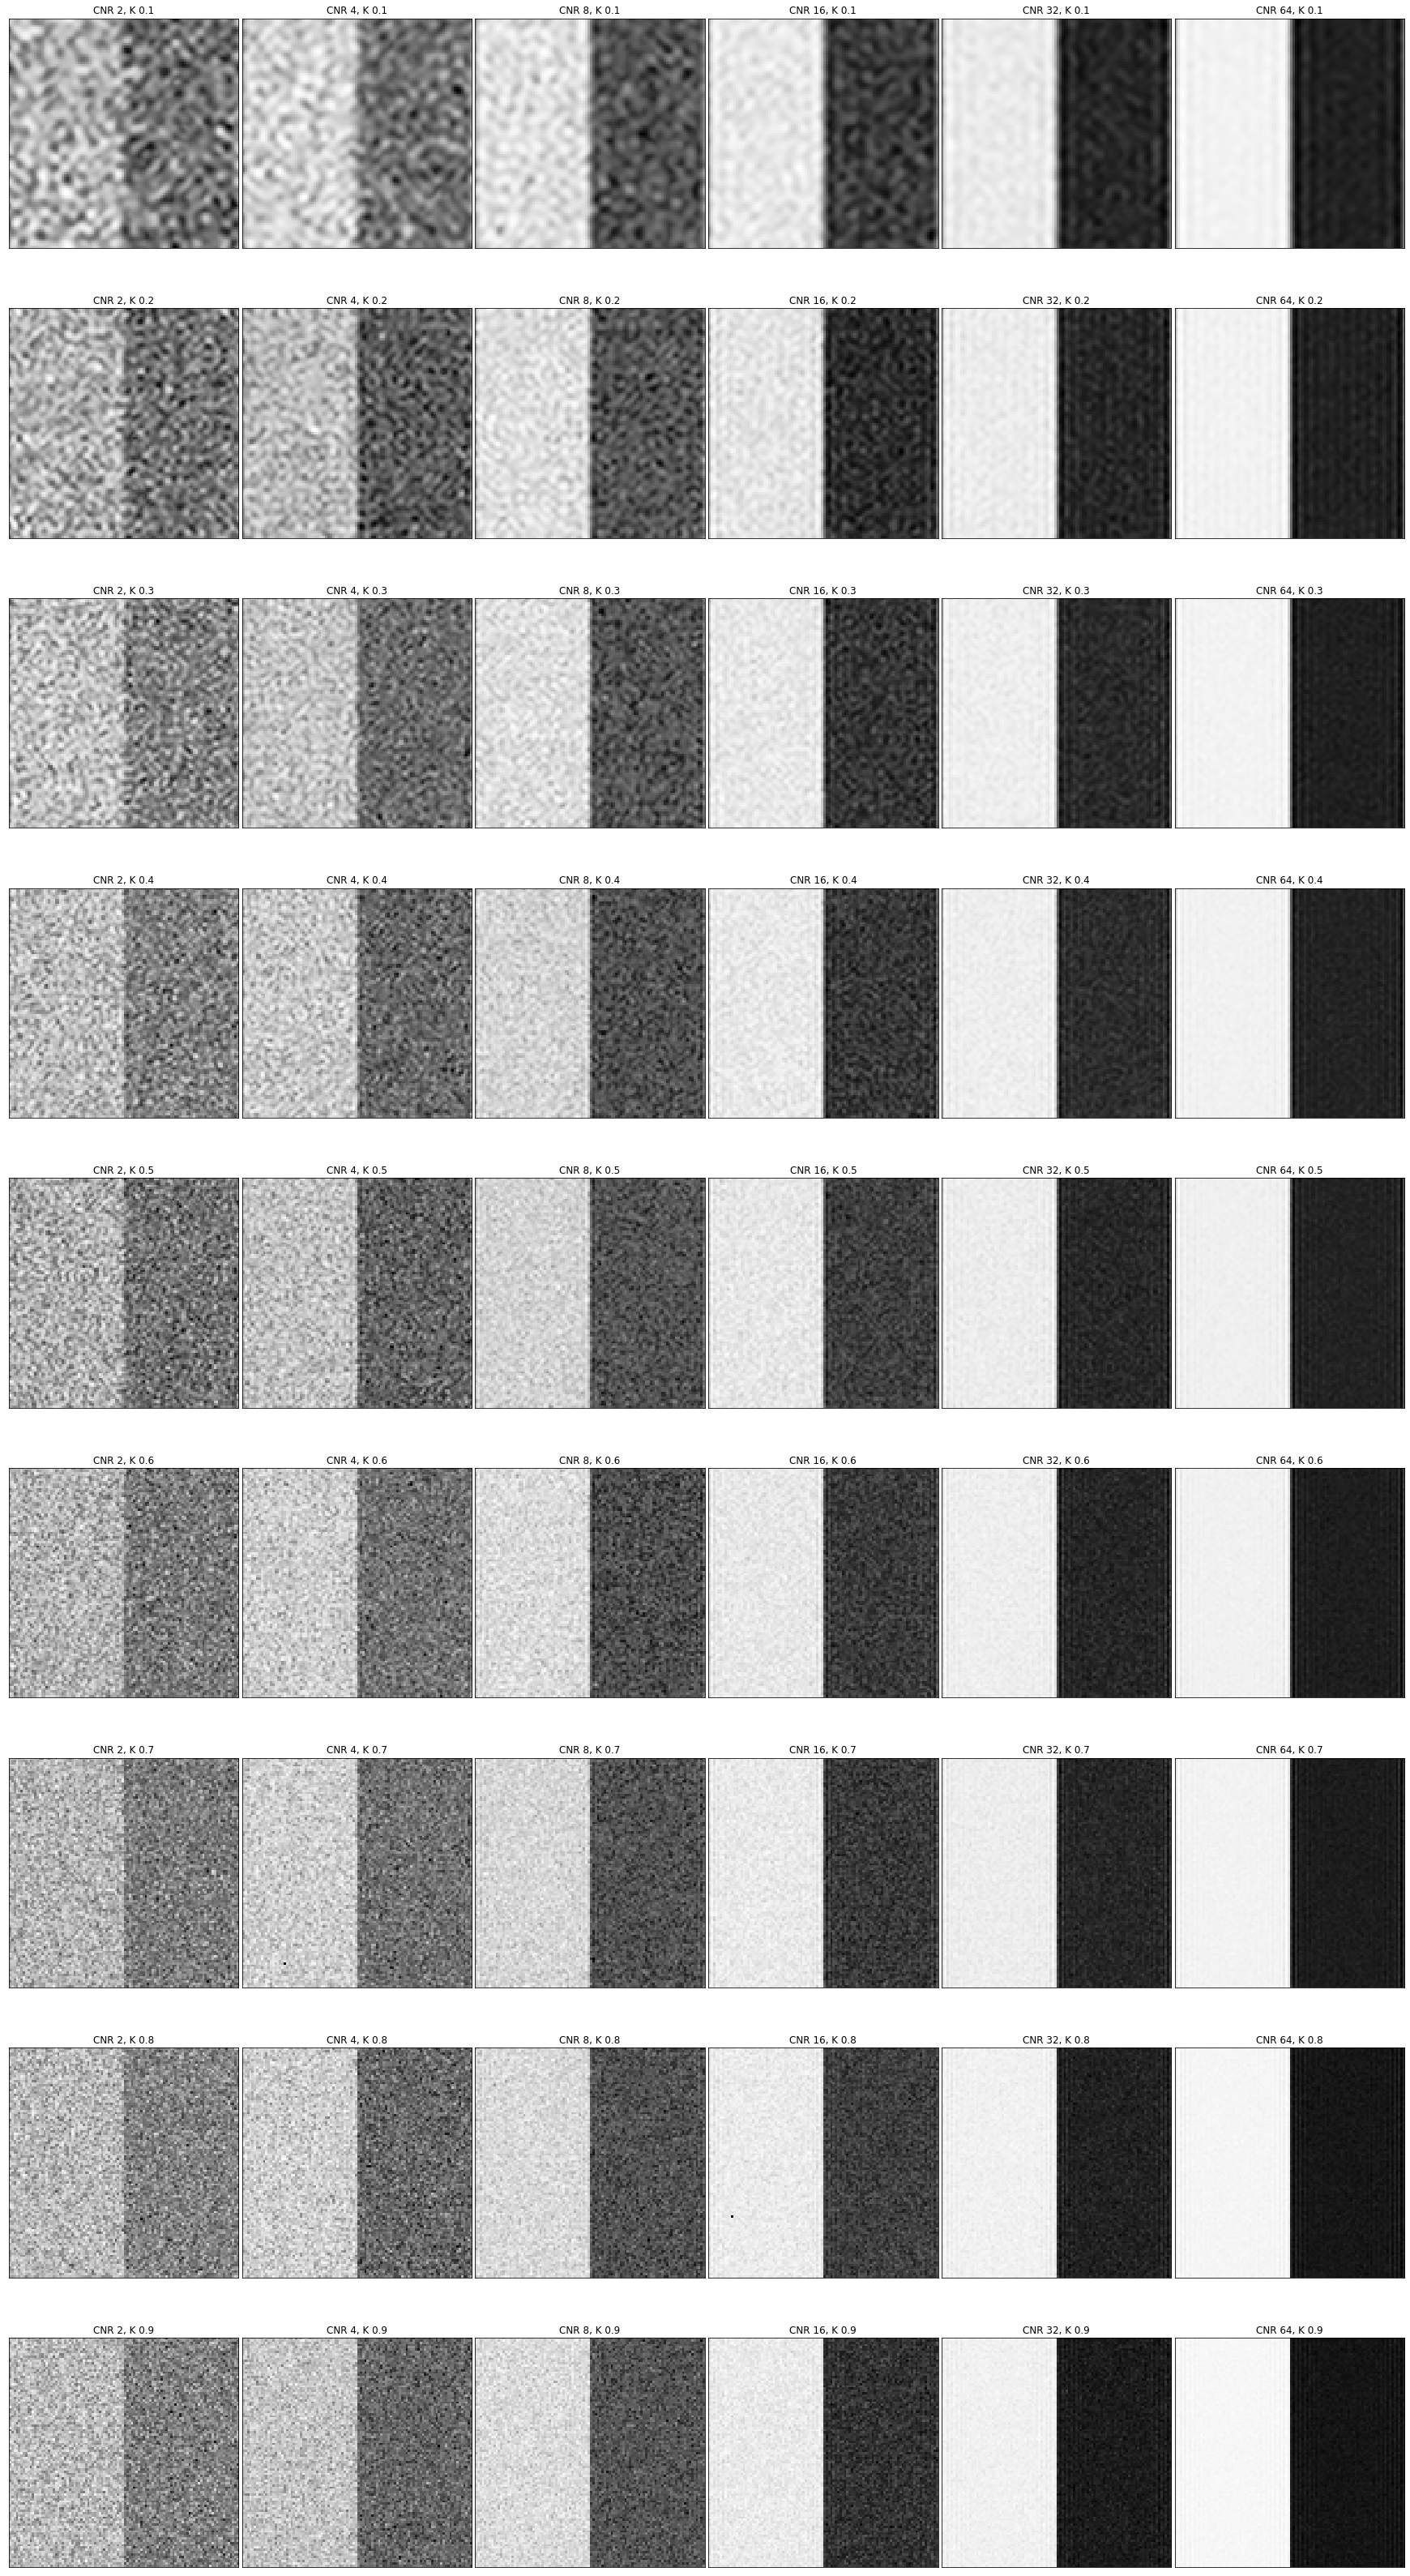

In [6]:
image_titles = [f'CNR {x[0]}, K {x[1]}' for x in param_descriptions][::images_per_setting]
images = noisy_images[::images_per_setting]
plot = plot_image_grid(images, image_titles, ncols=len(cnr_range))

# Fitting

In [7]:
fit_model_configuration = FittingConfiguration()
fit_model_configuration.model_type = 'deep'
fit_model_configuration.input_shape = [16, 16]
fit_model_configuration.number_of_hidden_channels = 40
fit_model_configuration.number_of_layers = 5
fit_model_configuration.log_frequency = 100
fit_model_configuration.convergence_check_length =  None
fit_model_configuration.number_of_iterations = 3000
fit_model_configuration.image_dimensions = [100,100,1]
fit_model_configuration.save_losses = False
fit_model_configuration.number_of_runs = 10
fit_model_configuration.find_best = False
fit_model_configuration.result_path = None
print(fit_model_configuration)

image_dimensions: [100, 100, 1]  
result_path: None  
model_type: deep  
input_shape: [16, 16]  
number_of_layers: 5  
number_of_hidden_channels: 40  
number_of_iterations: 3000  
number_of_runs: 10  
learning_rate: 0.1  
convergence_check_length: None  
log_frequency: 100  
find_best: False  
save_losses: False  
constant_input: False  
data_type: <class 'torch.cuda.FloatTensor'>  



In [ ]:
untrained_model_images = []
for image_index, noisy_image in enumerate(noisy_images):
    log_prefix = f'Image {image_index+1}/{len(noisy_images)}, '
    untrained_model_image = fit_model(noisy_image, fit_model_configuration, log_prefix)
    untrained_model_images.append(untrained_model_image)

In [ ]:
plot = plot_image_grid(untrained_model_images[::images_per_setting], image_titles, ncols=len(cnr_range))

# Load & Apply Trained Model

In [ ]:
path = 'models/trained_models/unet_magintude_pffact_8_snrlog0-5_nlayers_10.pt'
trained_model = UNetWavelet(in_ch=1, out_ch=1)
trained_model.load_state_dict(torch.load(path))
trained_model = trained_model.type(dtype)
trained_model = trained_model.eval()
for param in trained_model.parameters():
    param.requires_grad = False
#print(list(trained_model.parameters())[0].shape)
#summary(trained_model, (1, 100, 100), dtypes=[torch.cuda.FloatTensor], depth=3)

In [ ]:
trained_model_images = []
for noisy_image in noisy_images:
    noisy_tensor = image_to_tensor(noisy_image).unsqueeze(0).type(dtype)
    trained_image = trained_model(noisy_tensor)
    trained_model_image = tensor_to_image(trained_image.cpu().squeeze(0))
    trained_model_images.append(trained_model_image)

In [ ]:
plot = plot_image_grid(trained_model_images[::images_per_setting], image_titles, ncols=len(cnr_range))

# Calculating FWHMs

In [ ]:
untrained_fwhms = []
for image_index, untrained_model_image in enumerate(untrained_model_images):
    print(f'Image: {image_index+1}/{len(untrained_model_images)}', end='\r')
    fwhm = calculate_fwhm(untrained_model_image)
    untrained_fwhms.append(fwhm)
print('Finished calculating FWHMs for untrained reconstructions.')

trained_fwhms = []
for image_index, trained_model_image in enumerate(trained_model_images):
    print(f'Image: {image_index+1}/{len(trained_model_images)}', end='\r')
    fwhm = calculate_fwhm(trained_model_image)
    trained_fwhms.append(fwhm)
print('Finished calculating FWHMs for trained reconstructions.')

In [ ]:
CNRS, K_FACTORS = np.meshgrid(cnr_range,k_factors)

shape = (len(k_factors), len(cnr_range), images_per_setting)
untrained_fwhms = np.array(untrained_fwhms).reshape(shape)
trained_fwhms = np.array(trained_fwhms).reshape(shape)

invalid_untrained_fwhms = np.any(np.isnan(untrained_fwhms), axis=2)
invalid_trained_fwhms = np.any(np.isnan(trained_fwhms), axis=2)

untrained_fwhms[invalid_untrained_fwhms]=-1
trained_fwhms[invalid_trained_fwhms]=-1

untrained_fwhms_per_setup = np.mean(untrained_fwhms, axis=2)
trained_fwhms_per_setup = np.mean(trained_fwhms, axis=2)

fig = plt.figure(figsize=(12,6))

z_min = np.min((np.min(trained_fwhms_per_setup), np.min(untrained_fwhms_per_setup)))
z_max = np.max((np.max(trained_fwhms_per_setup), np.max(untrained_fwhms_per_setup)))

ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(CNRS, K_FACTORS, untrained_fwhms_per_setup)
ax.set_xlabel('CNR')
ax.set_ylabel('K-Factor')
ax.set_zlabel('FWHM')
ax.set_zlim3d(z_min, z_max)
ax.set_title('Untrained')

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(CNRS, K_FACTORS, trained_fwhms_per_setup)
ax.set_xlabel('CNR')
ax.set_ylabel('K-Factor')
ax.set_zlabel('FWHM')
ax.set_zlim3d(z_min, z_max)
ax.set_title('Trained')

plt.show()